the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-END to 60174.980688 from DATE-END'. [astropy.wcs.wcs]


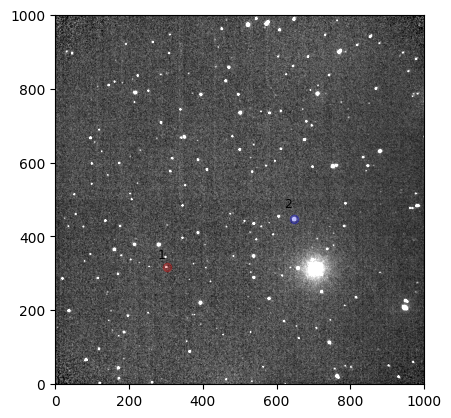

In [7]:
import os
import pandas as pd
from photometry import Photometry
from scripts.tools import sort_files
import astropy.io.fits as fits
import matplotlib.pyplot as plt
import numpy as np
from photometry import Photometry
from copy import copy

star_name = "GRB 230818A"
experiment = "all data"
_set = "first"
camera = 4
max_box_size = 20
src_path = os.path.join(
    "..",
    "Pol charact MOPTOP",
    "Scientific objects",
    star_name,
    experiment,
    f"{_set} set",
    "combined images",
)

GOOD_IMAGE = f"{camera}_e_run1.fits"
# GOOD_IMAGE = f"{camera}_e_20230818_5_1_1_1.fits"

file = os.path.join(src_path, GOOD_IMAGE)
image = fits.getdata(file)
median = np.median(image)
std = np.median(np.abs(image - median))
plt.imshow(
    image, vmax=median + 7 * std, vmin=median - 3 * std, origin="lower", cmap="gray"
)

csv_file = os.path.join(src_path, "..", f"objects coordinates.csv")
df = pd.read_csv(csv_file)
objects = {
    "name": df["name"],
    "ra": df[f"ra_{_set}_set_cam{camera}"],
    "dec": df[f"dec_{_set}_set_cam{camera}"],
}
objects = pd.DataFrame.from_dict(objects)
phot = Photometry(file, objects, max_box_size)
phot.reset_object_coords()
for idx, _object in enumerate(phot.obj_list):
    name, x, y = _object.name, _object.xcoord, _object.ycoord
    color = "b"
    if name == "original":
        color = "r"
    plt.plot(x, y, f"{color}o", alpha=0.25)
    plt.annotate(f"{idx+1}", (x * 0.99, y * 1.05), ha="right", va="bottom", fontsize=9)

plt.show()

# Create photometry.csv

In [9]:
objects_photometry = {}
for obj_name in objects["name"]:
    objects_photometry[obj_name] = {
        "mjd": [],
        "xcoord": [],
        "ycoord": [],
        "psf_radius": [],
        "star_photons": [],
        "star_error": [],
        "star_mag": [],
        "star_mag_err": [],
    }


image_list = sort_files(src_path, f"{camera}_e")
for file in image_list:
    try:
        file_path = os.path.join(src_path, file)

        phot = Photometry(file_path, objects, max_box_size)
        phot.reset_object_coords()
        phot.calc_psf_radius()
        phot.calc_sky_photons()
        phot.calc_psf_photons()

        for _object in phot.obj_list:
            objects_photometry[_object.name]["mjd"].append(_object.mjd)
            objects_photometry[_object.name]["xcoord"].append(_object.xcoord)
            objects_photometry[_object.name]["ycoord"].append(_object.ycoord)
            objects_photometry[_object.name]["psf_radius"].append(_object.psf_radius)
            objects_photometry[_object.name]["star_photons"].append(
                _object.star_photons
            )
            objects_photometry[_object.name]["star_error"].append(_object.star_err)
            objects_photometry[_object.name]["star_mag"].append(_object.star_mag)
            objects_photometry[_object.name]["star_mag_err"].append(
                _object.star_mag_err
            )
    except:
        continue


for obj_name, obj_info in objects_photometry.items():
    df = pd.DataFrame.from_dict(obj_info)
    csv_file = os.path.join(src_path, "..", "csv", f"{obj_name}_cam{camera}.csv")
    df.sort_values(by=["mjd"])
    df.to_csv(csv_file, index=False)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-END to 60174.980688 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 60174.981614 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 60174.982539 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 60174.983465 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 60174.984391 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 60174.985317 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 60174.986243 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 60174.987169 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 60174.988095 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 60174.989021 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 60174.989947 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 60174.990873 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 60174.991799 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 60174.992725 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 60174.993651 from DATE-END'. [astropy.wcs.wcs]
Se

# Plot light curve

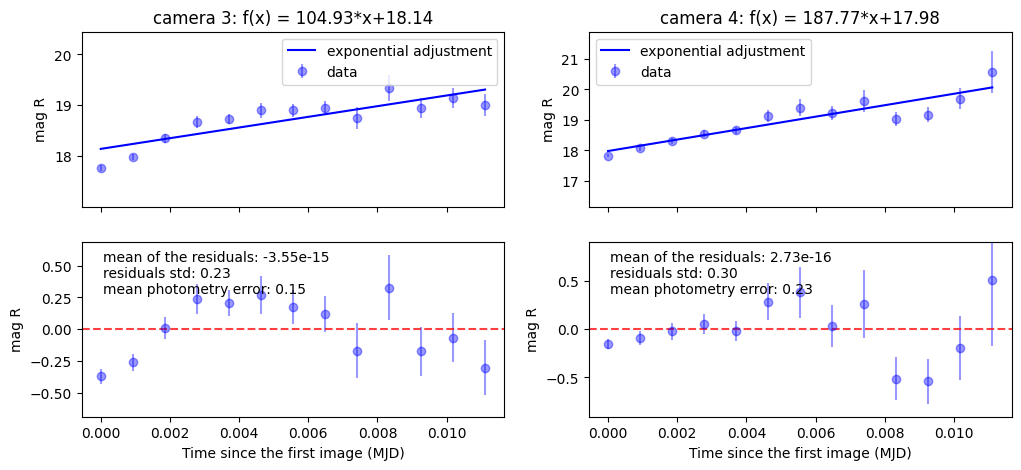

In [15]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
import scipy
from math import sqrt, log10


def monoExp(x, a, b, c):
    return a * np.exp(-b * x) + c


def read_csv_files(comparison_magnitude):
    cand, comp_1 = [], []
    for _set in ["first"]:
        csv_path = os.path.join(src_path, "..", "csv")
        csv_file = os.path.join(csv_path, f"comparison_cam{camera}.csv")
        comp_1.append(pd.read_csv(csv_file))
        csv_file = os.path.join(csv_path, f"original_cam{camera}.csv")
        cand.append(pd.read_csv(csv_file))
    n = 12
    df = pd.concat(cand, axis=0, ignore_index=True)
    cand = df["star_photons"][:n]
    cand_err = df["star_error"][:n]
    df = pd.concat(comp_1, axis=0, ignore_index=True)
    comp = df["star_photons"][:n]
    comp_err = df["star_error"][:n]

    star_mag, star_mag_err = calc_obj_magnitude(
        cand, cand_err, comp, comp_err, comparison_magnitude
    )

    mjd = df["mjd"][:n]
    mjd -= mjd[0]

    return mjd, star_mag, star_mag_err


def calc_obj_magnitude(star_photons, star_err, comp_photons, comp_err, mag_comparison):
    star_photons, comp_photons = np.asarray(star_photons), np.asarray(comp_photons)

    tmp = star_photons / comp_photons
    tmp_err = np.abs(tmp) * np.sqrt(
        (star_err / star_photons) ** 2 + (comp_err / comp_photons) ** 2
    )
    star_mag = -2.5 * np.log10(tmp) + mag_comparison
    star_mag_err = 2.5 * tmp_err / (tmp * np.log2(10))
    return star_mag, star_mag_err


def calc_exponential_adjust(x, y):
    params, _ = scipy.optimize.curve_fit(monoExp, x, y)
    a, b, c = params
    exp_adjust = monoExp(x, a, b, c)
    return exp_adjust, a, b, c


def calc_linear_adjust(x, y):
    a, b = np.polyfit(x, y, 1)
    return a * x + b, a, b


def plot_light_curve(ax, mjd, cand, cand_err, exp_adjust, adjus_param, n_std=1):
    a, b = adjus_param
    mean = np.mean(cand)
    std = np.std(cand)
    ax.errorbar(
        mjd, cand, cand_err, marker="o", color="b", alpha=0.4, label="data", ls="none"
    )

    ax.plot(mjd, exp_adjust, "b-", label="exponential adjustment")
    ax.set_title(f"camera {camera}: f(x) = {a:.2f}*x+{b:.2f}")
    ax.legend()
    ax.set_ylim(mean - n_std * std, mean + n_std * std)
    ax.set_ylabel("mag R")


def plot_residuals(ax, cand, cand_err, exp_adjust, n_std=3):
    residuals = cand - exp_adjust
    mean = np.mean(residuals)
    std = np.std(residuals)

    ax.errorbar(
        mjd,
        residuals,
        cand_err,
        marker="o",
        color="b",
        alpha=0.4,
        label="data",
        ls="none",
    )
    ax.set_ylabel("Residuals")
    ax.axhline(mean, color="r", linestyle="--", alpha=0.75)
    ax.set_ylim(mean - n_std * std, mean + n_std * std)
    ax.set_xlabel("Time since the first image (MJD)")
    ax.set_ylabel("mag R")
    ax.annotate(
        f"mean of the residuals: {mean:.2e}\nresiduals std: {std:.2f}\nmean photometry error: {np.mean(cand_err):.2f}",
        (0.05, 0.95),
        fontsize=10,
        ha="left",
        va="top",
        xycoords="axes fraction",
    )


comparison_magnitude = 14.406
fig, axs = plt.subplots(2, 2, figsize=(12, 5), sharex="col")
for camera in [3, 4]:
    mjd, star_mag, star_mag_err = read_csv_files(comparison_magnitude)
    exp_adjust, *adjus_param = calc_linear_adjust(mjd, star_mag)

    ax = axs[0, camera - 3]
    plot_light_curve(ax, mjd, star_mag, star_mag_err, exp_adjust, adjus_param, 4)

    ax = axs[1, camera - 3]
    plot_residuals(ax, star_mag, star_mag_err, exp_adjust, 3)


plt.savefig(os.path.join(src_path, "..", "light_curve.png"))
plt.show()

# Plot object coordinates over the image

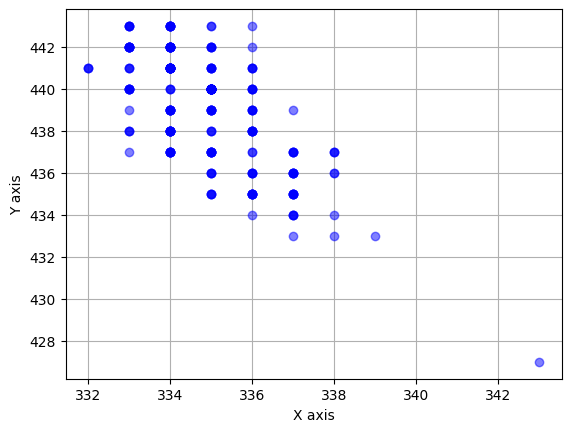

In [164]:
import matplotlib.pyplot as plt
import pandas as pd
import os

star_name = "GRB 230818A"
experiment = "all data"
src_path = os.path.join(
    "..",
    "Pol charact MOPTOP",
    "Scientific objects",
    star_name,
    experiment,
    "comdined images",
)

csv_file = os.path.join(src_path, "csv", "first set", "candidate_1_cam3.csv")
df = pd.read_csv(csv_file)
plt.plot(df["xcoord"], df["ycoord"], "bo", alpha=0.5)
# plt.xlim(0, 1024)
# plt.ylim(0, 1024)
plt.xlabel(("X axis"))
plt.ylabel("Y axis")
plt.grid()
plt.show()

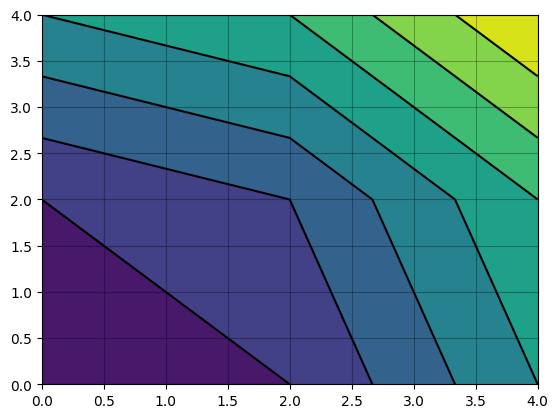

In [10]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(0, 4, 3)
y = x
(
    x,
    y,
) = np.meshgrid(x, y)
z = x**2 + y**2
fig, ax = plt.subplots(1, 1)
cs = ax.contourf(x, y, z)
ax.contour(cs, colors="k")
ax.grid(c="k", ls="-", alpha=0.3)

plt.show()